In [8]:
import math
import pandas as pd
import numpy as np
import torch
import pickle

from scipy.spatial import ConvexHull
from PolyRound.api import PolyRoundApi
import arviz as az
import matplotlib.pyplot as plt

from sbmfi.models.small_models import spiro
from sbmfi.core.polytopia import (
    extract_labelling_polytope, 
    simplify_polytope,
    transform_polytope_keep_transform, 
    round_polytope_keep_ellipsoid,
    LabellingPolytope,
    sample_polytope,
    MarkovTransition,
    V_representation,
    get_rounded_polytope,
)
from sbmfi.core.linalg import LinAlg
from sbmfi.core.coordinater import FluxCoordinateMapper
from sbmfi.priors.mog import MixtureOfGaussians, create_polytope
from sbmfi.inference.arxiv_polytope_plotter import plot_dataframes

%matplotlib inline

### Defining and transforming the polytope

In [2]:
model, kwargs = spiro(backend='torch', seed=0, device='cpu')

for reaction in model.reactions:
    print(reaction, reaction.bounds)

polytope = extract_labelling_polytope(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-27


C:\python_projects\sbmfi\venv\lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


a_in:  --> A/ab (10.0, 10.0)
d_out: D/abc -->  (0.0, 100.0)
f_out: F/a -->  (0.0, 100.0)
h_out: H/ab -->  (0.0, 100.0)
v1: A/ab --> B/ab (0.0, 100.0)
v2: B/ab --> E/ab (0.0, 100.0)
v3: B/ab + E/cd --> C/abcd + cof (0.0, 100.0)
v4: E/ab --> H/ab (0.0, 100.0)
v5: F/a + D/bcd <-- C/abcd (-100.0, 0.0)
v6: D/abc --> E/ab + F/c (0.0, 100.0)
v7: F/a + F/b --> H/ab (0.0, 100.0)
bm: 0.3 H/. + 0.6 B/. + 0.5 E/. + 0.1 C/. -->  (0.05, 1.5)
EX_cof: cof -->  (0.0, 1000.0)


Below, all equality constraints. The right-most column is the $\vec{h}$ vector.

In [45]:
fcm = FluxCoordinateMapper(model, kernel_id='rref')
psm = fcm.sampler

v_representation = V_representation(get_rounded_polytope(psm))
convhull = ConvexHull(v_representation.values)

pickle.dump((fcm, v_representation, convhull.volume), open('spiro_flux_coordinate_mapper.p', 'wb'))

In [12]:
pd.concat([polytope.S, polytope.h.to_frame()], axis=1)

,EX_cof,v1,v2,v3,v4,v5_rev,v6,v7,d_out,f_out,h_out,bm,a_in,eq
A,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
D,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0
F,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-2.0,0.0,-1.0,0.0,0.0,0.0,0
H,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.0,-0.3,0.0,0
B,0.0,1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.6,0.0,0
E,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0
C,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-0.1,0.0,0
cof,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Below, all inequality constraints. The right-most column is the $\vec{b}_c$ vector.

In [13]:
pd.concat([polytope.A, polytope.b.to_frame()], axis=1)

,EX_cof,v1,v2,v3,v4,v5_rev,v6,v7,d_out,f_out,h_out,bm,a_in,ub
EX_cof|lb,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
EX_cof|ub,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.00
a_in|lb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-10.00
a_in|ub,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.00
bm|lb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-0.05
bm|ub,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.50
d_out|lb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.00
d_out|ub,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100.00
f_out|lb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.00
f_out|ub,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,100.00


In [14]:
simple_polytope = simplify_polytope(polytope, normalize=False)
simple_polytope.S

,EX_cof,v1,v2,v3,v4,v5_rev,v6,v7,d_out,f_out,h_out,bm,a_in
a_in|lb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
A,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
D,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-2.0,0.0,-1.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.0,-0.3,0.0
B,0.0,1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.6,0.0
E,0.0,0.0,1.0,-1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.5,0.0
C,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-0.1,0.0
cof,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Below, the transformation matrix $T$ choosing the row reduced echelon kernel

In [15]:
transformed_polytope, T, T_1, tau = transform_polytope_keep_transform(simple_polytope, kernel_id='rref')
tau.columns = ['tau']
pd.concat([T, tau], axis=1)

,v7,f_out,h_out,bm,tau
EX_cof,1.0,0.333333,-0.333333,-0.433333,3.333333
v1,0.0,0.000000,0.000000,0.000000,10.000000
v2,-1.0,-0.333333,0.333333,-0.166667,6.666667
v3,1.0,0.333333,-0.333333,-0.433333,3.333333
v4,-1.0,0.000000,1.000000,0.300000,0.000000
v5_rev,1.0,0.333333,-0.333333,-0.533333,3.333333
v6,1.0,0.666667,0.333333,0.533333,-3.333333
v7,1.0,0.000000,0.000000,0.000000,0.000000
d_out,0.0,-0.333333,-0.666667,-1.066667,6.666667
f_out,0.0,1.000000,0.000000,0.000000,0.000000


The resulting transformed polytope $\mathcal{F}^\dagger$ 

In [16]:
pd.concat([transformed_polytope.A, transformed_polytope.b.to_frame()], axis=1)

,v7,f_out,h_out,bm,0
bm|lb,0.0,0.000000,0.000000,-1.000000,-0.050000
bm|ub,0.0,0.000000,0.000000,1.000000,1.500000
d_out|lb,0.0,0.333333,0.666667,1.066667,6.666667
f_out|lb,0.0,-1.000000,0.000000,0.000000,0.000000
h_out|lb,0.0,0.000000,-1.000000,0.000000,0.000000
v4|lb,1.0,0.000000,-1.000000,-0.300000,0.000000
v6|lb,-1.0,-0.666667,-0.333333,-0.533333,-3.333333
v7|lb,-1.0,0.000000,0.000000,0.000000,0.000000


Matrix $E$ which maps the unit ball to the maximum volume ellipsoid in $\mathcal{F}^\dagger$ 

In [17]:
rounded_polytope, E, E_1, epsilon = round_polytope_keep_ellipsoid(transformed_polytope)
epsilon.columns = ['epsilon']
pd.concat([E, epsilon], axis=1)

,R_v7,R_f_out,R_h_out,R_bm,epsilon
v7,2.248125,0.000000,0.000000,0.000000,2.248125
f_out,-1.432895,4.261816,0.000000,0.000000,4.496250
h_out,1.554474,-0.965025,1.947163,0.000000,4.263750
bm,-0.075987,-0.105715,-0.248177,0.668643,0.775000


The Jones polytope, centered at the origin and whose facets touch the unit ball

In [18]:
pd.concat([rounded_polytope.A, rounded_polytope.b.to_frame()], axis=1)

,R_v7,R_f_out,R_h_out,R_bm,0
bm|lb,0.075987,0.105715,0.248177,-0.668643,0.725000
bm|ub,-0.075987,-0.105715,-0.248177,0.668643,0.725000
d_out|lb,0.477632,0.664493,1.033386,0.713219,1.498750
f_out|lb,1.432895,-4.261816,0.000000,0.000000,4.496250
h_out|lb,-1.554474,0.965025,-1.947163,0.000000,4.263750
v4|lb,0.716447,0.996739,-1.872710,-0.200593,2.248125
v6|lb,-1.770493,-2.463154,-0.516693,-0.356610,3.746875
v7|lb,-2.248125,0.000000,0.000000,0.000000,2.248125


The cell below creates a polytope sampling model `psm`, where the above transformations are sequentially applied. The `fcm` is an object that allows for mapping between different coordinate systems.

In [20]:
np.isclose(fcm._sampler._G, rounded_polytope.A.values).all()  # sampler

True

### Target distribution: mixture of $n$ Gaussians in a ball or polytope

We align the means of the MoG with the axes, so that the multi-modality shows up in the plots

In [21]:
n = 3
gen = torch.Generator().manual_seed(3)
K = psm.dimensionality

if n > K:
    raise ValueError('Come on now.')

means = torch.eye(psm.dimensionality) * 0.9 ** (1/K)
means = torch.cat([means, -means])

perm = torch.randperm(means.shape[0], generator=gen)
which_means = perm[:n]
means = means[which_means]

weights = torch.randint(low=1, high=5, size=torch.Size((n, )), dtype=torch.double, generator=gen)
weights /= weights.sum()

covs = torch.eye(means.shape[-1])
covs = torch.stack([covs] * means.shape[0]) * weights[:, None, None] / 8  # means that the distributions with less weight are more concentrated, good for plotting

target = MixtureOfGaussians(means=means, covariances=covs, weights=weights)
target.means

tensor([[ 0.0000,  0.0000,  0.9740,  0.0000],
        [-0.9740, -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.9740]])

### Computing $Z$ for the target with polytope support

Since the target is an un-normalized density over the polytope, we need to compute the normalizing constant first.

$$
Z \approx \text{Vol}(P) \times \frac{1}{N} \sum_{i=1}^{N} f(x_i)
$$

Where the samples f(x)

In [22]:
def diagnostics(data: az.InferenceData):
    return pd.DataFrame([
        az.ess(data, var_names=["theta"]).theta.values,
        az.rhat(data, var_names=["theta"]).theta.values
    ], index=['ess', 'rhat'], columns=data.posterior.theta.theta_id.values)

In [18]:
# uniform_result = sample_polytope(
#     model=psm,
#     n = 100000,
#     n_burn = 1000,
#     initial_points = None,
#     thinning_factor = 10,
#     n_chains = 8,
#     return_psm = False,
#     phi = None,
#     linalg = None,
#     markov_transition= None,
#     return_what='chains',    
# )

# uniform_data = az.from_dict(
#     posterior={
#         'theta': uniform_result['chains'].permute(1,0,2)  # chains x draws x param
#     },
#     dims={'theta': ['theta_id']},
#     coords={'theta_id': psm.rounded_id},
#     attrs={
#         'n_burn': 1000,
#         'thinning_factor': 10,
#         'n_chains': 8,
#     }
# )

In [19]:
unif_file = 'unif_polytope_100k_samples.nc'
# uniform_data.to_netcdf(unif_file)
uniform_data = az.from_netcdf(unif_file)

array([<Axes: title={'center': 'theta\nR_v7'}>,
       <Axes: title={'center': 'theta\nR_f_out'}>,
       <Axes: title={'center': 'theta\nR_h_out'}>,
       <Axes: title={'center': 'theta\nR_bm'}>], dtype=object)

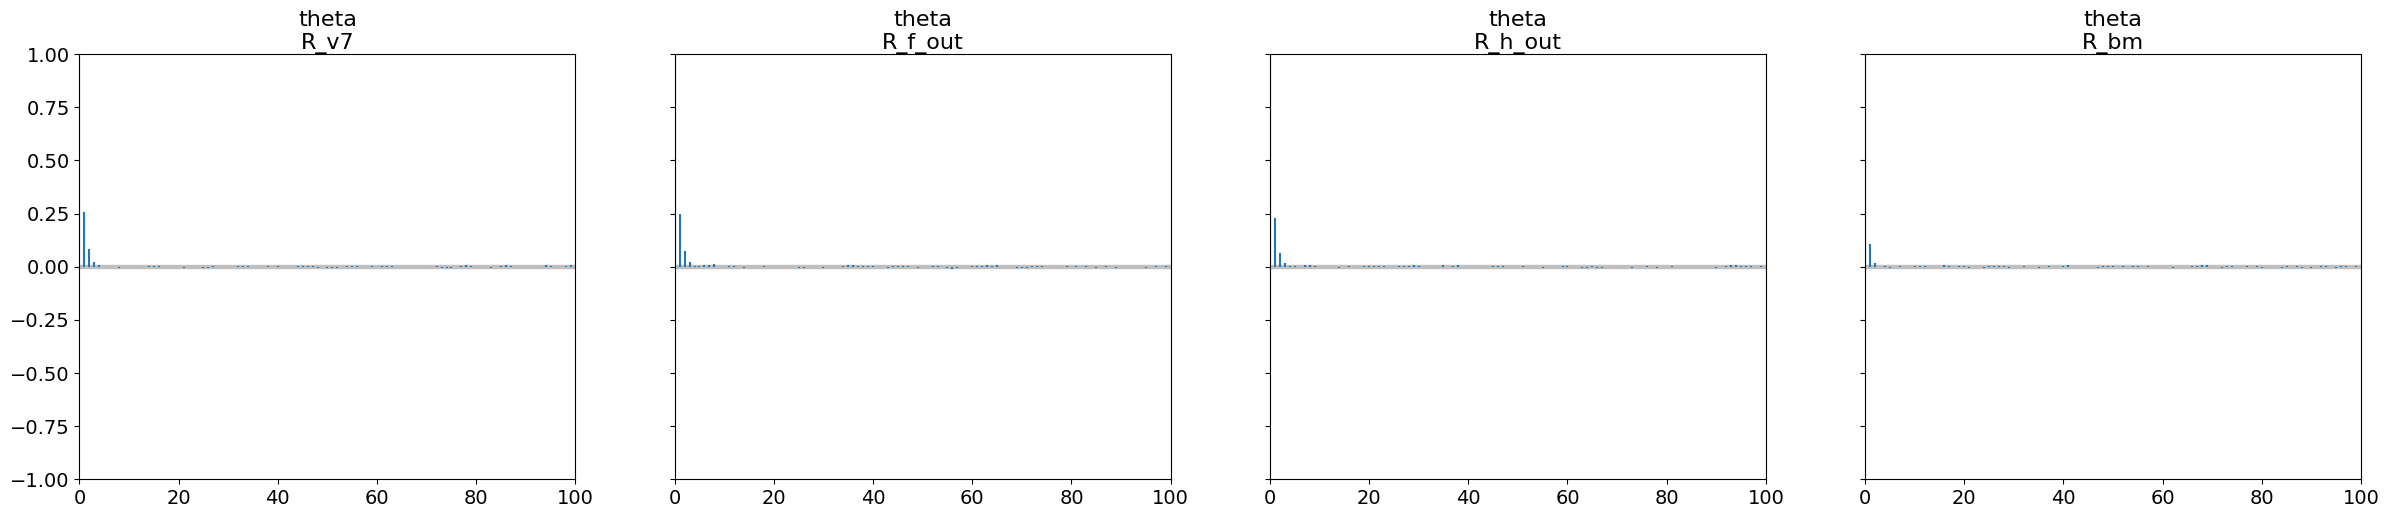

In [20]:
az.plot_autocorr(uniform_data, combined=True)

array([<Axes: title={'center': 'theta\nR_v7'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'theta\nR_f_out'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'theta\nR_h_out'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'theta\nR_bm'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

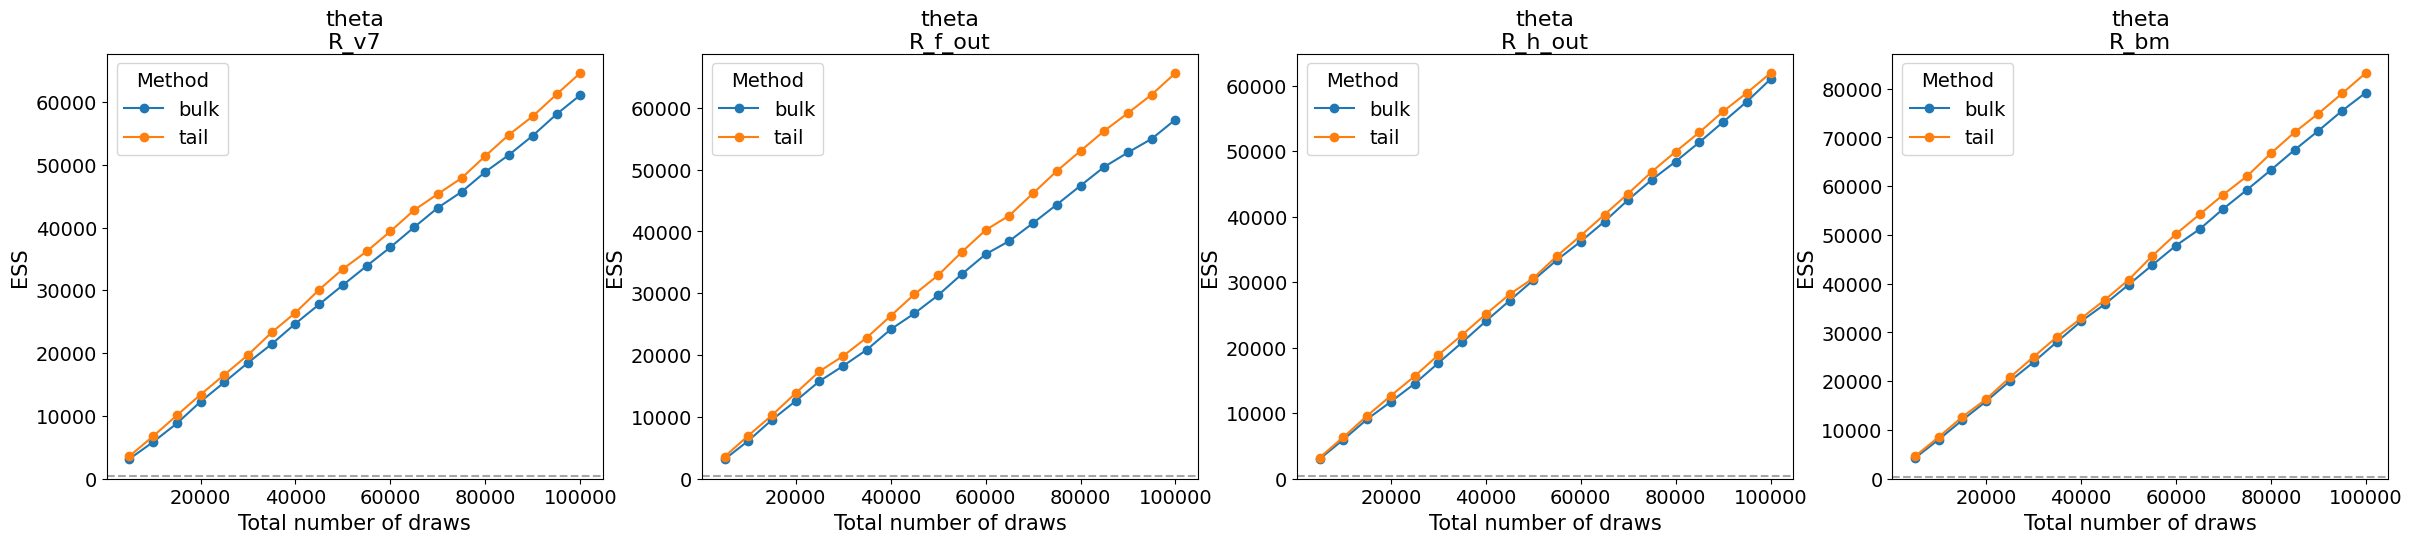

In [21]:
az.plot_ess(uniform_data, var_names=["theta"], kind="evolution")

In [22]:
diagnostics(uniform_data)

,R_v7,R_f_out,R_h_out,R_bm
ess,61087.845441,58107.796476,61021.294146,79199.277728
rhat,0.999996,1.000082,1.000199,1.000050


In [27]:
uniform_theta = torch.as_tensor(
    az.extract(uniform_data, combined=True, var_names='theta', keep_dataset=False, rng=2).values
).T
Z = convhull.volume * (1 / uniform_theta.shape[0]) * torch.exp(target.log_prob(uniform_theta)).sum()
Z

tensor(0.7159)

### Sampling from the target distribution
define suitable proposal distribution

In [20]:
transition_kwargs = dict(
    n_cdf=3,
    transition_id='peskun',
    proposal_id='unif',
    chord_std=1.0,
)

markov = MarkovTransition(
    psm, 
    target, 
    **transition_kwargs
)

In [21]:
sampling_kwargs = dict(
    n_burn = 1000,
    thinning_factor = 15,
    n_chains = 8,
)

# mog_res = sample_polytope(
#     model=psm,
#     n = 100000,
#     markov_transition=markov,
#     return_what='chains',    
#     **sampling_kwargs
# )

In [22]:
# mog_data = az.from_dict(
#     posterior={
#         'theta': mog_res['chains'].permute(1,0,2)  # chains x draws x param
#     },
#     dims={'theta': ['theta_id']},
#     coords={'theta_id': psm.rounded_id},
#     sample_stats={
#         'lp': mog_res['log_probs'].T  # chains x draws
#     },
#     attrs={**{
#         'acceptanced': mog_res['acceptanced'].numpy(), 
#         'tot_steps': mog_res['tot_steps'],
#         'mog_means': target.means.numpy(),
#         'mog_covs': target.covariances.numpy(),
#         'mog_weights': target.weights.numpy(),
#         'mog_Z': Z.numpy(),
#     }, **transition_kwargs, **sampling_kwargs}
# )

In [23]:
mog_file = 'mog_polytope_100k_samples.nc'
# mog_data.to_netcdf(mog_file)

mog_data = az.from_netcdf(mog_file)

In [24]:
diagnostics(mog_data) #

,R_v7,R_f_out,R_h_out,R_bm
ess,20384.746295,61922.668303,15695.114764,17609.962871
rhat,1.000195,1.000062,1.000256,1.000405


array([<Axes: title={'center': 'theta\nR_v7'}>,
       <Axes: title={'center': 'theta\nR_f_out'}>,
       <Axes: title={'center': 'theta\nR_h_out'}>,
       <Axes: title={'center': 'theta\nR_bm'}>], dtype=object)

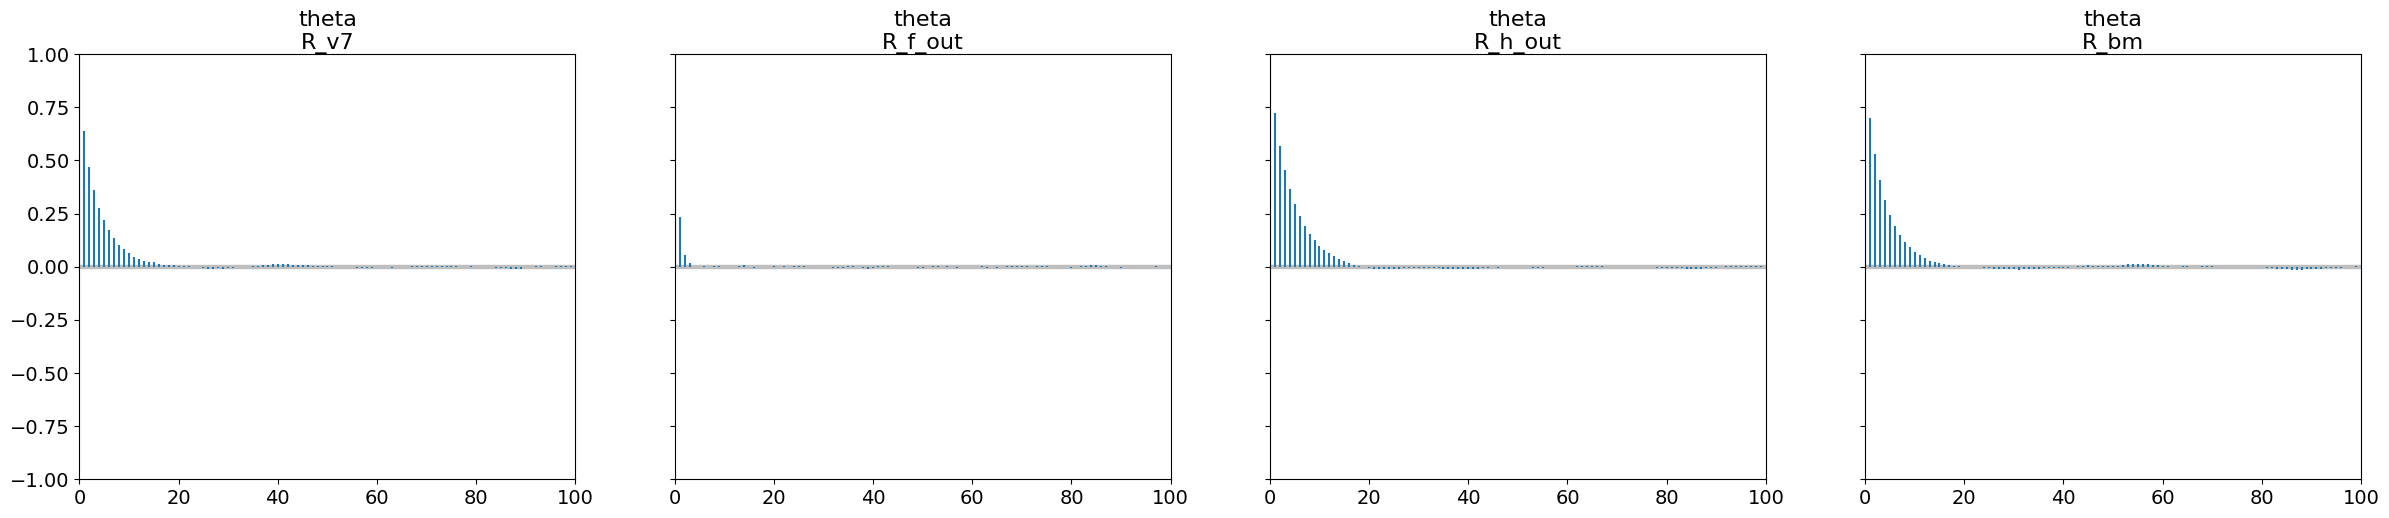

In [25]:
az.plot_autocorr(mog_data, combined=True)

array([<Axes: title={'center': 'theta\nR_v7'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'theta\nR_f_out'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'theta\nR_h_out'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'theta\nR_bm'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

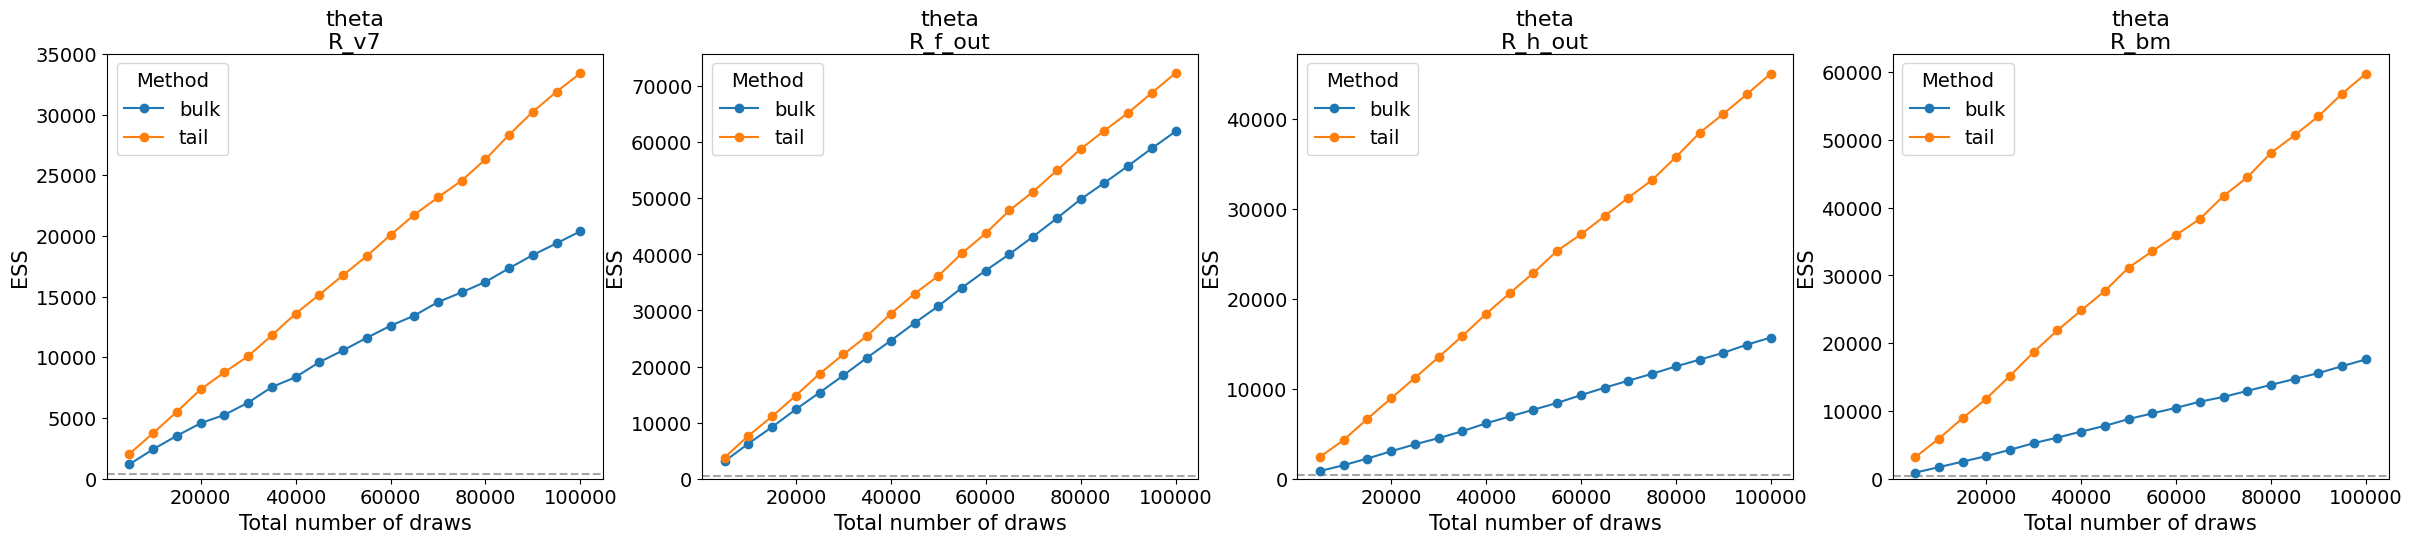

In [26]:
az.plot_ess(mog_data, var_names=["theta"], kind="evolution")

In [26]:
means_df = pd.DataFrame(np.hstack([mog_data.attrs['mog_means'], mog_data.attrs['mog_weights'][:, None]]), columns=fcm.theta_id().append(pd.Index(['weights'])))
mog_theta_df = pd.DataFrame(
    az.extract(mog_data, combined=True, var_names='theta', keep_dataset=False, rng=2).values, index=mog_data.posterior.theta_id.values
).T

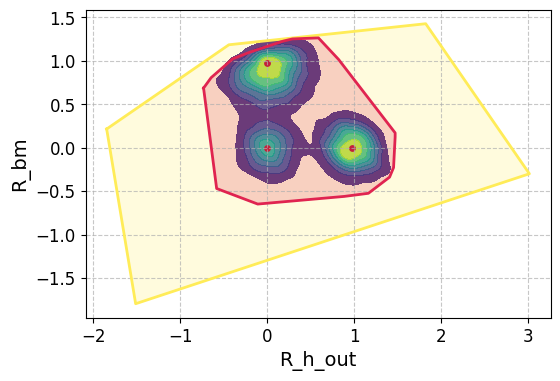

In [8]:
plt.ioff()

fig, ax = plot_dataframes(
    vertices=v_representation,
    samples=mog_theta_df[:5000],
    points=means_df,
    x_col='R_h_out', 
    y_col='R_bm',
    x_label='R_h_out', 
    y_label='R_bm',
    label1='Polytope', 
    label2='Samples Convex Hull',
    label3='Samples KDE Density', 
    label4='Additional Points',
    bw_method=None,
    bw_adjust=0.6,
    levels=8,
    font_dict=None,
    vertices_fill_color='#ffec58',
    samples_fill_color='#e02450',
    figsize=(6, 4),
    show_legend=False,
    legend_loc='best',
    s_points=15,
    points_color='#C41E3A',
)
plt.show()

In [17]:
plt.savefig(
    'target.svg', transparent=None, dpi='figure', format='svg',
    metadata=None, bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto', backend=None,
)

### K dimensional polytope

For the machine learning section, we would like to make a comparison to a higher dimensional polytope, hence we two more datasets for a $K$ dimensional polytope

In [28]:
import random
import string
import itertools
from sbmfi.core.polytopia import PolytopeSamplingModel

def generate_unique_random_strings(K):
    # Create all possible 3-letter strings (using lowercase letters)
    all_strings = [''.join(p) for p in itertools.product(string.ascii_lowercase, repeat=3)]
    if K > len(all_strings):
        raise ValueError(f"K={K} exceeds the maximum number of unique 3-letter strings ({len(all_strings)})")
    return random.sample(all_strings, K)

In [36]:
K = 15
A, b = create_polytope(K=15)

K_pol = LabellingPolytope(
    A=pd.DataFrame(A, columns=generate_unique_random_strings(K)), 
    b=pd.Series(b),
)
psm = PolytopeSamplingModel(K_pol, linalg=LinAlg(backend='torch'))

In [37]:
n = 3
gen = torch.Generator().manual_seed(3)

if n > K:
    raise ValueError('Come on now.')

means = torch.eye(psm.dimensionality) * 0.9 ** (1/K)
means = torch.cat([means, -means])

means = means[[0,1,2]]

weights = torch.randint(low=1, high=5, size=torch.Size((n, )), dtype=torch.double, generator=gen)
weights /= weights.sum()

covs = torch.eye(means.shape[-1])
covs = torch.stack([covs] * means.shape[0]) * weights[:, None, None] / 8  # means that the distributions with less weight are more concentrated, good for plotting

target = MixtureOfGaussians(means=means, covariances=covs, weights=weights)
target.means

tensor([[0.9930, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9930, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9930, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [31]:
# Kunif_result = sample_polytope(
#     model=psm,
#     n = 100000,
#     n_burn = 1000,
#     initial_points = None,
#     thinning_factor = 10,
#     n_chains = 8,
#     return_psm = False,
#     phi = None,
#     linalg = None,
#     markov_transition= None,
#     return_what='chains',    
# )

# Kunif_data = az.from_dict(
#     posterior={
#         'theta': np.transpose(Kunif_result['chains'], (1,0,2))  # chains x draws x param
#     },
#     dims={'theta': ['theta_id']},
#     coords={'theta_id': psm.rounded_id},
#     attrs={
#         'n_burn': 1000,
#         'thinning_factor': 10,
#         'n_chains': 8,
#     }
# )

In [38]:
Kunif_file = 'Kunif_polytope_100k_samples.nc'
# Kunif_data.to_netcdf(Kunif_file)
# Kunif_data = az.from_netcdf(Kunif_file)

In [39]:
transition_kwargs = dict(
    n_cdf=3,
    transition_id='peskun',
    proposal_id='unif',
    chord_std=1.0,
)

markov = MarkovTransition(
    psm, 
    target, 
    **transition_kwargs
)

In [49]:
# sampling_kwargs = dict(
#     n_burn = 1000,
#     thinning_factor = 15,
#     n_chains = 8,
# )

# Kmog_res = sample_polytope(
#     model=psm,
#     n = 100000,
#     markov_transition=markov,
#     return_what='chains',    
#     **sampling_kwargs
# )

In [68]:
Kmog_data = az.from_dict(
    posterior={
        'theta': Kmog_res['chains'].permute(1,0,2)  # chains x draws x param
    },
    dims={'theta': ['theta_id']},
    coords={'theta_id': psm.rounded_id},
    sample_stats={
        'lp': Kmog_res['log_probs'].T  # chains x draws
    },
    attrs={**{
        'A': A,
        'b': b,
        'A_cols': psm.rounded_id,
        'acceptanced': Kmog_res['acceptanced'].numpy(), 
        'tot_steps': Kmog_res['tot_steps'],
        'mog_means': target.means.numpy(),
        'mog_covs': target.covariances.numpy(),
        'mog_weights': target.weights.numpy(),
    }, **transition_kwargs, **sampling_kwargs}
)

In [31]:
Kmog_file = 'Kmog_polytope_100k_samples.nc'
# Kmog_data.to_netcdf(Kmog_file)

Kmog_data = az.from_netcdf(Kmog_file)

In [40]:
# from sbmfi.core.polytopia import V_representation
# Kv_representation = V_representation(get_rounded_polytope(Kpsm), vertices_tol=0.0)
# Kv_representation.to_csv('Kv_representation.csv')
Kv_representation = pd.read_csv('Kv_representation.csv', index_col=0)
means_df = pd.DataFrame(
    np.hstack([Kmog_data.attrs['mog_means'], Kmog_data.attrs['mog_weights'][:, None]]), 
    columns=Kv_representation.columns.append(pd.Index(['weights']))
)
mog_theta_df = pd.DataFrame(
    az.extract(Kmog_data, combined=True, var_names='theta', keep_dataset=False, rng=2).values, index=Kmog_data.posterior.theta_id.values
).T

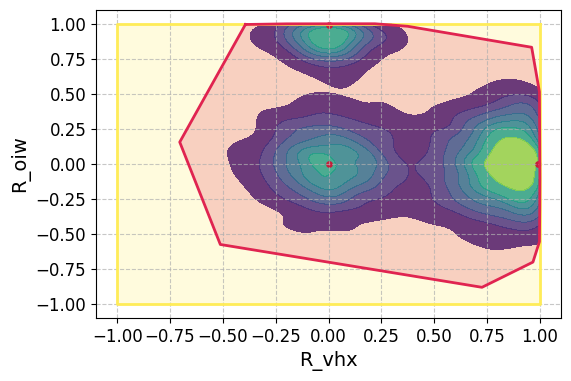

In [43]:
plt.ioff()

fig, ax = plot_dataframes(
    vertices=Kv_representation,
    samples=mog_theta_df[:5000],
    points=means_df,
    x_col='R_vhx', 
    y_col='R_oiw',
    x_label='R_vhx', 
    y_label='R_oiw',
    label1='Polytope', 
    label2='Samples Convex Hull',
    label3='Samples KDE Density', 
    label4='Additional Points',
    bw_method=None,
    bw_adjust=0.6,
    levels=8,
    font_dict=None,
    vertices_fill_color='#ffec58',
    samples_fill_color='#e02450',
    figsize=(6, 4),
    show_legend=False,
    legend_loc='best',
    s_points=15,
    points_color='#C41E3A',
)
plt.show()